# Prepare Datasets

In [ ]:
!unzip edv.zip -d /content/edv/

In [ ]:

!unzip esv.zip -d /content/esv/

# Model and Dataset Classes

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights



class VolumeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
        self.keypoint_fc = nn.Sequential(
            nn.Linear(80, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        self.area_fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 128 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, area, keypoints):
        x_img = self.resnet_backbone(image).squeeze()
        x_kp = self.keypoint_fc(keypoints)
        x_area = self.area_fc(area)
        x = torch.cat([x_img, x_kp, x_area], dim=1)
        return self.combined_fc(x).squeeze(1)


In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Dataset
class EFVolumeDataset(Dataset):
    def __init__(self, metadata_path, image_dir):
        with open(metadata_path, 'r') as f:
            self.entries = json.load(f)
        self.image_dir = Path(image_dir)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        image_filename = f"{item['video_id']}_f{item['frame_num']}.jpg"
        image_path = self.image_dir / image_filename

        image = self.transform(Image.open(image_path).convert("RGB"))
        area = torch.tensor([item["area"]], dtype=torch.float32)
        keypoints = torch.tensor(item["keypoints"], dtype=torch.float32)
        volume = torch.tensor([item["volume"]], dtype=torch.float32)

        return image, area, keypoints, volume

# EDV Regressor Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import r2_score

# Paths
metadata_path = "/content/edv/edv/metadata.json"
image_dir = "/content/edv/edv/"

# Dataset
full_dataset = EFVolumeDataset(metadata_path, image_dir)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
full_dataset = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [ ]:
# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
train_losses = []
val_losses = []
val_r2_scores = []

best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_path = "best_model_edv.pt"

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, areas, keypoints, volumes in train_loader:
        images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)

        preds = model(images, areas, keypoints)
        volumes = volumes.squeeze(1)  # Now volumes is [B] to match preds
        loss = criterion(preds.view(-1), volumes.view(-1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, areas, keypoints, volumes in val_loader:
            images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)
            preds = model(images, areas, keypoints)
            volumes = volumes.squeeze(1)
            loss = criterion(preds.view(-1), volumes.view(-1))
            val_loss += loss.item()

            y_true.extend(volumes.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    r2 = r2_score(y_true, y_pred)
    val_losses.append(val_loss)
    val_r2_scores.append(r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R²: {r2:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
        print("✅ Model improved — saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best model after training
model.load_state_dict(torch.load(best_model_path))


Epoch 1 | Train Loss: 3387.4605 | Val Loss: 698.4106 | Val R²: 0.6377
✅ Model improved — saved.
Epoch 2 | Train Loss: 696.2171 | Val Loss: 654.0315 | Val R²: 0.6613
✅ Model improved — saved.
Epoch 3 | Train Loss: 510.7703 | Val Loss: 813.4750 | Val R²: 0.5814
⚠️ No improvement. Patience: 1/15
Epoch 4 | Train Loss: 400.2299 | Val Loss: 812.2452 | Val R²: 0.5793
⚠️ No improvement. Patience: 2/15
Epoch 5 | Train Loss: 303.5368 | Val Loss: 633.1292 | Val R²: 0.6712
✅ Model improved — saved.
Epoch 6 | Train Loss: 243.3625 | Val Loss: 772.5507 | Val R²: 0.5988
⚠️ No improvement. Patience: 1/15
Epoch 7 | Train Loss: 201.6881 | Val Loss: 639.5721 | Val R²: 0.6670
⚠️ No improvement. Patience: 2/15
Epoch 8 | Train Loss: 177.0076 | Val Loss: 560.9230 | Val R²: 0.7092
✅ Model improved — saved.
Epoch 9 | Train Loss: 163.7402 | Val Loss: 682.7135 | Val R²: 0.6457
⚠️ No improvement. Patience: 1/15
Epoch 10 | Train Loss: 146.9942 | Val Loss: 659.3355 | Val R²: 0.6575
⚠️ No improvement. Patience: 2/15


<All keys matched successfully>

In [ ]:
# Save model
torch.save(model.state_dict(), "edv.pt")

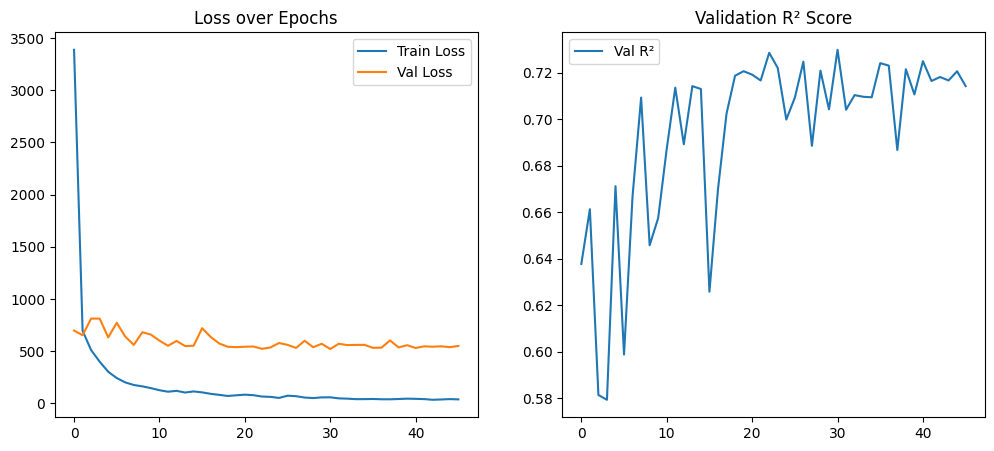

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label="Val R²")
plt.title("Validation R² Score")
plt.legend()
plt.show()


In [ ]:
from google.colab import files
files.download('best_model_edv.pt')

In [ ]:
import torch
from sklearn.metrics import r2_score

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
model.load_state_dict(torch.load('best_model_edv.pt', map_location=torch.device('cpu')))

model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, areas, keypoints, volumes in full_dataset:
        images = images.to(device)
        areas = areas.to(device)
        keypoints = keypoints.to(device)
        volumes = volumes.to(device)

        preds = model(images, areas, keypoints)
        test_preds.extend(preds.view(-1).cpu().numpy())
        test_targets.extend(volumes.view(-1).cpu().numpy())

print(f"[DEBUG] Collected {len(test_preds)} predictions and {len(test_targets)} targets")

if len(test_preds) > 0:
    mse = torch.mean((torch.tensor(test_preds) - torch.tensor(test_targets)) ** 2).item()
    r2 = r2_score(test_targets, test_preds)
    print(f"\n📊 Test Loss (MSE): {mse:.4f} | R² Score: {r2:.4f}")
else:
    print("❌ No predictions made — check test_loader or model.")


[DEBUG] Collected 10024 predictions and 10024 targets

📊 Test Loss (MSE): 582.7209 | R² Score: 0.7206


/tmp/ipython-input-4158674025.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


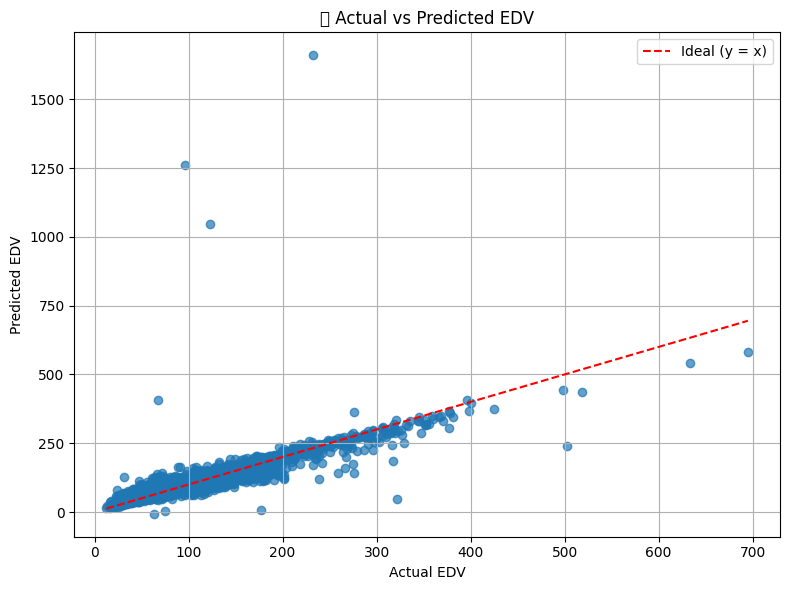

In [ ]:
import matplotlib.pyplot as plt

# Convert to numpy arrays (if not already)
import numpy as np
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', label='Ideal (y = x)')
plt.xlabel("Actual EDV")
plt.ylabel("Predicted EDV")
plt.title("📈 Actual vs Predicted EDV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ESV Regressor Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import r2_score

# Paths
metadata_path = "/content/edv/edv/metadata.json"
image_dir = "/content/edv/edv/"

# Dataset
full_dataset = EFVolumeDataset(metadata_path, image_dir)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
full_dataset = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [ ]:


# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
train_losses = []
val_losses = []
val_r2_scores = []

best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_path = "best_model_esv.pt"

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, areas, keypoints, volumes in train_loader:
        images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)

        preds = model(images, areas, keypoints)
        volumes = volumes.squeeze(1)  # Now volumes is [B] to match preds
        loss = criterion(preds.view(-1), volumes.view(-1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, areas, keypoints, volumes in val_loader:
            images, areas, keypoints, volumes = images.to(device), areas.to(device), keypoints.to(device), volumes.to(device)
            preds = model(images, areas, keypoints)
            volumes = volumes.squeeze(1)
            loss = criterion(preds.view(-1), volumes.view(-1))
            val_loss += loss.item()

            y_true.extend(volumes.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    r2 = r2_score(y_true, y_pred)
    val_losses.append(val_loss)
    val_r2_scores.append(r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R²: {r2:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
        print("✅ Model improved — saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best model after training
model.load_state_dict(torch.load(best_model_path))


Epoch 1 | Train Loss: 1075.1120 | Val Loss: 501.7593 | Val R²: 0.5697
✅ Model improved — saved.
Epoch 2 | Train Loss: 438.7433 | Val Loss: 624.0359 | Val R²: 0.4653
⚠️ No improvement. Patience: 1/15
Epoch 3 | Train Loss: 297.9585 | Val Loss: 567.7433 | Val R²: 0.5127
⚠️ No improvement. Patience: 2/15
Epoch 4 | Train Loss: 236.9583 | Val Loss: 375.9125 | Val R²: 0.6775
✅ Model improved — saved.
Epoch 5 | Train Loss: 199.6178 | Val Loss: 363.4295 | Val R²: 0.6886
✅ Model improved — saved.
Epoch 6 | Train Loss: 169.2422 | Val Loss: 340.2305 | Val R²: 0.7087
✅ Model improved — saved.
Epoch 7 | Train Loss: 129.4241 | Val Loss: 328.9133 | Val R²: 0.7177
✅ Model improved — saved.
Epoch 8 | Train Loss: 115.3897 | Val Loss: 417.0330 | Val R²: 0.6419
⚠️ No improvement. Patience: 1/15
Epoch 9 | Train Loss: 112.0005 | Val Loss: 352.5030 | Val R²: 0.6974
⚠️ No improvement. Patience: 2/15
Epoch 10 | Train Loss: 102.0058 | Val Loss: 637.8881 | Val R²: 0.4520
⚠️ No improvement. Patience: 3/15
Epoch 11

<All keys matched successfully>

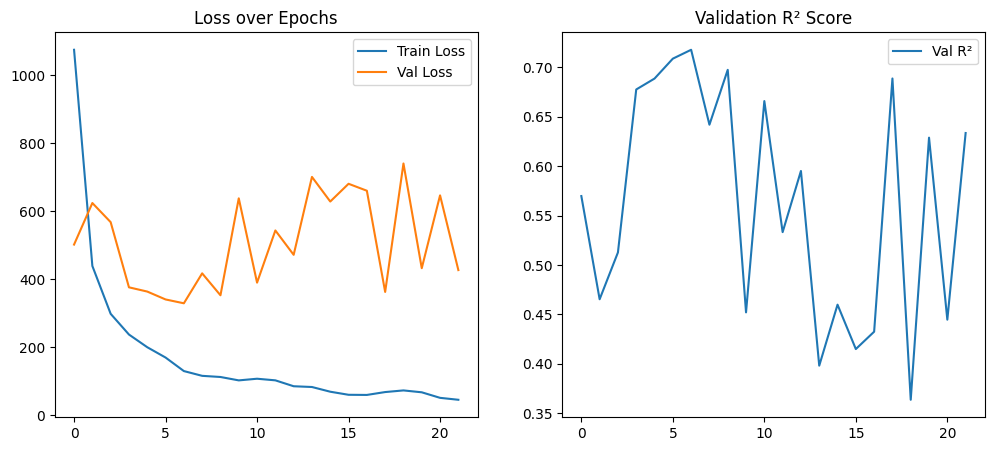

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label="Val R²")
plt.title("Validation R² Score")
plt.legend()
plt.show()


In [ ]:
from google.colab import files
files.download('best_model_esv.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from sklearn.metrics import r2_score

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
model.load_state_dict(torch.load('best_model_esv.pt', map_location=torch.device('cpu')))

model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, areas, keypoints, volumes in full_dataset:
        images = images.to(device)
        areas = areas.to(device)
        keypoints = keypoints.to(device)
        volumes = volumes.to(device)

        preds = model(images, areas, keypoints)
        test_preds.extend(preds.view(-1).cpu().numpy())
        test_targets.extend(volumes.view(-1).cpu().numpy())

print(f"[DEBUG] Collected {len(test_preds)} predictions and {len(test_targets)} targets")

if len(test_preds) > 0:
    mse = torch.mean((torch.tensor(test_preds) - torch.tensor(test_targets)) ** 2).item()
    r2 = r2_score(test_targets, test_preds)
    print(f"\n📊 Test Loss (MSE): {mse:.4f} | R² Score: {r2:.4f}")
else:
    print("❌ No predictions made — check test_loader or model.")


[DEBUG] Collected 10024 predictions and 10024 targets

📊 Test Loss (MSE): 142.6793 | R² Score: 0.8889


/tmp/ipython-input-2565453926.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


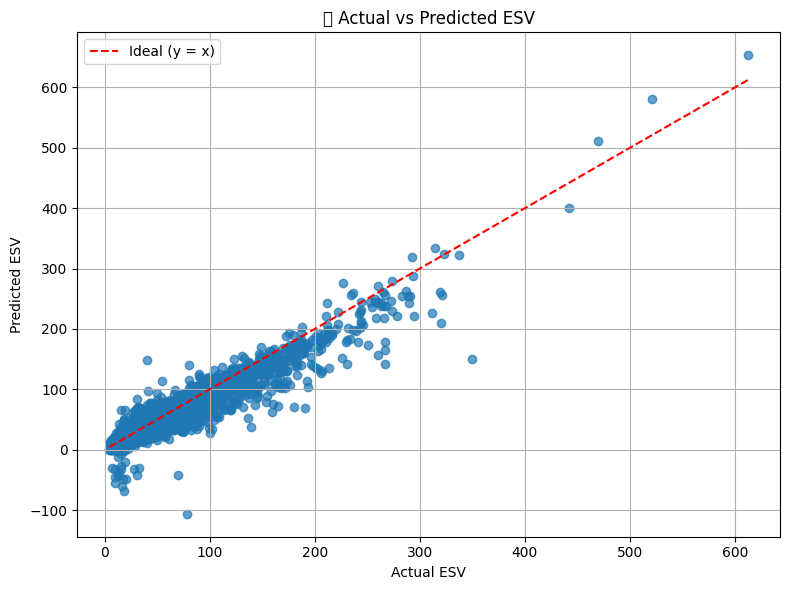

In [ ]:
import matplotlib.pyplot as plt

# Convert to numpy arrays (if not already)
import numpy as np
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', label='Ideal (y = x)')
plt.xlabel("Actual ESV")
plt.ylabel("Predicted ESV")
plt.title("📈 Actual vs Predicted ESV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from sklearn.metrics import r2_score

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VolumeRegressor().to(device)
model.load_state_dict(torch.load('best_model_esv.pt', map_location=torch.device('cpu')))

model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for images, areas, keypoints, volumes in full_dataset:
        images = images.to(device)
        areas = areas.to(device)
        keypoints = keypoints.to(device)
        volumes = volumes.to(device)

        preds = model(images, areas, keypoints)
        test_preds.extend(preds.view(-1).cpu().numpy())
        test_targets.extend(volumes.view(-1).cpu().numpy())

print(f"[DEBUG] Collected {len(test_preds)} predictions and {len(test_targets)} targets")

if len(test_preds) > 0:
    mse = torch.mean((torch.tensor(test_preds) - torch.tensor(test_targets)) ** 2).item()
    r2 = r2_score(test_targets, test_preds)
    print(f"\n📊 Test Loss (MSE): {mse:.4f} | R² Score: {r2:.4f}")
else:
    print("❌ No predictions made — check test_loader or model.")


[DEBUG] Collected 10024 predictions and 10024 targets

📊 Test Loss (MSE): 6277.4292 | R² Score: -2.0099


# ESV Model Evaluaed on the EDV Dataset

/tmp/ipython-input-2565453926.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


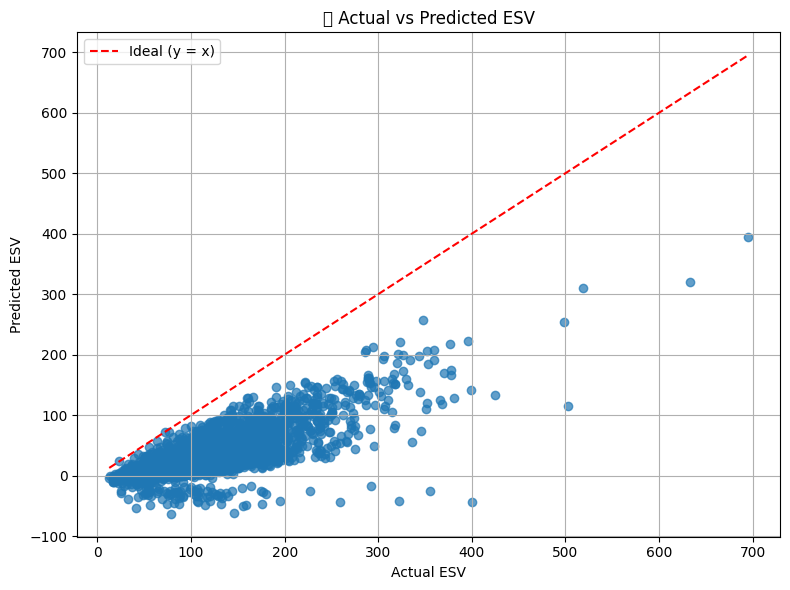

In [ ]:
import matplotlib.pyplot as plt

# Convert to numpy arrays (if not already)
import numpy as np
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', label='Ideal (y = x)')
plt.xlabel("Actual ESV")
plt.ylabel("Predicted ESV")
plt.title("📈 Actual vs Predicted ESV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Combined CNN

In [1]:
!unzip joint_esv_edv_dataset.zip -d /content/joint_esv_edv_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X200A81BEC98DEB6D_edv_f67.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X204AE811B3916921_esv_f155.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X204AE811B3916921_edv_f133.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X206AE6EE14B44F6D_esv_f93.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X20C397F012441121_edv_f49.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X20C66395A83A2333_esv_f14.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X20C66395A83A2333_edv_f0.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/val/images/0X2109CB4DF22133B8_esv_f64.jpg  
  inflating: /content/joint_esv_edv_dataset/joint_esv_edv_dataset/va

In [2]:
import json
import numpy as np
from pathlib import Path

# Path to your train metadata
meta_path = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset/train/metadata.json")

# Load all entries
with open(meta_path, 'r') as f:
    entries = json.load(f)

all_kps = []    # will be list of shape-(80,) arrays
all_areas = []  # list of scalars

for e in entries:
    all_kps.append(np.array(e["keypoints"], dtype=np.float32))
    all_areas.append(float(e["area"]))

all_kps = np.stack(all_kps, axis=0)       # shape (N, 80)
all_areas = np.array(all_areas)           # shape (N,)

# Compute mean & std
kp_mean = all_kps.mean(axis=0)            # (80,)
kp_std  = all_kps.std(axis=0)             # (80,)
area_mean = all_areas.mean()              # scalar
area_std  = all_areas.std()               # scalar

print("Keypoint mean shape:", kp_mean.shape)
print("Keypoint std  shape:", kp_std.shape)
print("Area mean:", area_mean)
print("Area std :", area_std)

# If you prefer a single scalar for keypoints (shared across dims):
print("Overall KP mean:", kp_mean.mean())
print("Overall KP std :", kp_std.mean())


Keypoint mean shape: (80,)
Keypoint std  shape: (80,)
Area mean: 1154.2236595174263
Area std : 548.001330460863
Overall KP mean: 54.444458
Overall KP std : 7.221002


In [3]:
import yaml
import numpy as np
from pathlib import Path


# Create a dict that’s YAML-serializable
stats = {
    'kp_mean': kp_mean.tolist(),
    'kp_std':  kp_std.tolist(),
    'area_mean': float(area_mean),
    'area_std':  float(area_std),
}

# Write to stats.yaml
out_path = Path("input_stats.yaml")
with out_path.open('w') as f:
    yaml.safe_dump(stats, f, default_flow_style=False)

print(f"Saved normalization stats to {out_path.resolve()}")


Saved normalization stats to /content/input_stats.yaml


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import json
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────────
ROOT = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset/")
BATCH_SIZE = 32             # increased batch size
LR = 1e-4
EPOCHS = 50                # increased epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── MODEL ─────────────────────────────────────────────────────────────────────
class DualVolumeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # Shared image backbone
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        # modify stem to accept grayscale if needed:
        # backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.img_encoder = nn.Sequential(*list(backbone.children())[:-1])  # remove FC

        # Shared keypoint MLP
        self.kp_fc = nn.Sequential(
            nn.Linear(80, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.3)
        )
        # Shared area MLP
        self.area_fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16),
            nn.Dropout(0.3)
        )

        # Combined regressor head
        total_feat = 2 * (512 + 128 + 16)
        self.head = nn.Sequential(
            nn.Linear(total_feat, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2),   # predict [esv, edv]
            nn.ReLU()
        )

    def forward(self, img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv):
        f_esv = self.img_encoder(img_esv).flatten(1)
        k_esv = self.kp_fc(kp_esv)
        a_esv = self.area_fc(area_esv)

        f_edv = self.img_encoder(img_edv).flatten(1)
        k_edv = self.kp_fc(kp_edv)
        a_edv = self.area_fc(area_edv)

        x = torch.cat([f_esv, k_esv, a_esv, f_edv, k_edv, a_edv], dim=1)
        return self.head(x)

# ─── DATASET ───────────────────────────────────────────────────────────────────
class DualEFVolumeDataset(Dataset):
    def __init__(self, metadata_path, image_dir, stats_path="input_stats.yaml"):
        with open(metadata_path, 'r') as f:
            self.entries = json.load(f)
        self.img_dir = Path(image_dir)

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        import yaml
        with open(stats_path, 'r') as sf:
            stats = yaml.safe_load(sf)
        self.kp_mean   = torch.tensor(stats['kp_mean'], dtype=torch.float32)
        self.kp_std    = torch.tensor(stats['kp_std'],  dtype=torch.float32)
        self.area_mean = float(stats['area_mean'])
        self.area_std  = float(stats['area_std'])

    def __len__(self):
        return len(self.entries) // 2

    def __getitem__(self, idx):
        esv_entry = self.entries[2 * idx]
        edv_entry = self.entries[2 * idx + 1]

        def load(e):
            name = f"{e['video_id']}_{e['label']}_f{e['frame_num']}.jpg"
            img = Image.open(self.img_dir / name).convert("L")
            img = self.transform(img)
            kp = (torch.tensor(e["keypoints"], dtype=torch.float32) - self.kp_mean) / self.kp_std
            area = (torch.tensor([e["area"]], dtype=torch.float32) - self.area_mean) / self.area_std
            vol = torch.tensor([e["volume"]], dtype=torch.float32)
            return img, area, kp, vol

        img_esv, area_esv, kp_esv, vol_esv = load(esv_entry)
        img_edv, area_edv, kp_edv, vol_edv = load(edv_entry)

        return (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), \
               torch.tensor([vol_esv, vol_edv], dtype=torch.float32)

In [5]:

# ─── DATA LOADERS ─────────────────────────────────────────────────────────────
train_ds = DualEFVolumeDataset(ROOT/"train"/"metadata.json", ROOT/"train"/"images/")
val_ds   = DualEFVolumeDataset(ROOT/"val"/"metadata.json",   ROOT/"val"/"images/")
test_ds  = DualEFVolumeDataset(ROOT/"test"/"metadata.json",  ROOT/"test"/"images/")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ─── MODEL, LOSS, OPTIMIZER & SCHEDULER ────────────────────────────────────────
model = DualVolumeRegressor().to(DEVICE)
# Combined MSE + EF loss
def ef_loss(esv_pred, edv_pred, esv_gt, edv_gt):
    ef_pred = (edv_pred - esv_pred) / (edv_pred + 1e-6)
    ef_gt   = (edv_gt   - esv_gt)   / (edv_gt   + 1e-6)
    return nn.MSELoss()(ef_pred, ef_gt)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [ ]:

from tqdm import tqdm
import time

train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch # {epoch}')
    start_time = time.time()

    # ─ Train ─
    model.train()
    running_train = 0.0
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False):
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        esv_pred, edv_pred = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv).unbind(1)
        loss_main = criterion(torch.stack([esv_pred, edv_pred], dim=1), targets)
        loss_ef   = ef_loss(esv_pred, edv_pred, targets[:,0], targets[:,1])
        loss = loss_main + 0.3 * loss_ef
        loss.backward()
        optimizer.step()

        running_train += loss_main.item() * img_esv.size(0)

    train_loss = running_train / len(train_ds)
    train_losses.append(train_loss)

    # ─ Validation ─
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False):
            img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
            img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
            targets = targets.to(DEVICE)

            esv_pred, edv_pred = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv).unbind(1)
            loss_main = criterion(torch.stack([esv_pred, edv_pred], dim=1), targets)
            running_val += loss_main.item() * img_esv.size(0)

    val_loss = running_val / len(val_ds)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

    # ─ Test ─
    running_test = 0.0
    with torch.no_grad():
        for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(test_loader, desc=f"Epoch {epoch}/{EPOCHS} [Test]", leave=False):
            img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
            img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
            targets = targets.to(DEVICE)

            preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
            loss_main = criterion(preds, targets)
            running_test += loss_main.item() * img_esv.size(0)

    test_loss = running_test / len(test_ds)
    test_losses.append(test_loss)

    scheduler.step()

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} | Train: {train_loss:.3f} | Val: {val_loss:.3f} | Test: {test_loss:.3f} | Time: {elapsed:.1f}s")

print(f"Training complete. Best model saved to '{best_model_path}' with val loss {best_val_loss:.4f}")


Epoch # 1


Epoch 1/50 | Train: 5464.293 | Val: 3310.246 | Test: 3407.515 | Time: 94.8s
Epoch # 2


Epoch 2/50 | Train: 2304.805 | Val: 1563.366 | Test: 1653.812 | Time: 94.3s
Epoch # 3


Epoch 3/50 | Train: 1730.214 | Val: 1454.495 | Test: 1547.082 | Time: 94.4s
Epoch # 4


Epoch 4/50 | Train: 1659.075 | Val: 1383.123 | Test: 1475.943 | Time: 95.4s
Epoch # 5


Epoch 5/50 | Train: 1569.201 | Val: 1315.001 | Test: 1406.242 | Time: 94.5s
Epoch # 6


Epoch 6/50 | Train: 1511.285 | Val: 1241.169 | Test: 1334.489 | Time: 94.7s
Epoch # 7


Epoch 7/50 | Train: 1447.921 | Val: 1178.264 | Test: 1270.045 | Time: 95.7s
Epoch # 8


Epoch 8/50 | Train: 1370.518 | Val: 1123.725 | Test: 1211.311 | Time: 93.9s
Epoch # 9


Epoch 9/50 | Train: 1320.219 | Val: 1067.993 | Test: 1158.847 | Time: 94.9s
Epoch # 10


Epoch 10/50 | Train: 1266.763 | Val: 1039.172 | Test: 1123.878 | Time: 93.7s
Epoch # 11


Epoch 11/50 | Train: 1237.065 | Val: 1006.048 | Test: 1089.484 | Time: 94.0s
Epoch # 12


Epoch 12/50 | Train: 1184.906 | Val: 976.507 | Test: 1056.557 | Time: 94.6s
Epoch # 13


Epoch 13/50 | Train: 1159.432 | Val: 947.066 | Test: 1021.687 | Time: 94.6s
Epoch # 14


Epoch 14/50 | Train: 1132.835 | Val: 935.944 | Test: 1003.920 | Time: 93.8s
Epoch # 15


Epoch 15/50 | Train: 1112.866 | Val: 899.337 | Test: 973.138 | Time: 94.2s
Epoch # 16


Epoch 16/50 | Train: 1112.747 | Val: 885.747 | Test: 953.387 | Time: 94.0s
Epoch # 17


Epoch 17/50 | Train: 1076.569 | Val: 879.437 | Test: 945.008 | Time: 93.3s
Epoch # 18


Epoch 18/50 | Train: 1039.989 | Val: 857.917 | Test: 921.636 | Time: 93.7s
Epoch # 19


Epoch 19/50 | Train: 1064.014 | Val: 842.320 | Test: 902.624 | Time: 94.1s
Epoch # 20


Epoch 20/50 | Train: 1021.709 | Val: 830.046 | Test: 887.338 | Time: 93.9s
Epoch # 21


Epoch 21/50 | Train: 1041.332 | Val: 818.601 | Test: 872.412 | Time: 93.5s
Epoch # 22


Epoch 22/50 | Train: 1002.681 | Val: 806.577 | Test: 860.938 | Time: 93.7s
Epoch # 23


Epoch 23/50 | Train: 986.110 | Val: 800.306 | Test: 847.992 | Time: 94.3s
Epoch # 24


Epoch 24/50 | Train: 993.997 | Val: 790.340 | Test: 837.692 | Time: 94.4s
Epoch # 25


Epoch 25/50 | Train: 982.362 | Val: 786.389 | Test: 833.776 | Time: 93.8s
Epoch # 26


Epoch 26/50 | Train: 965.672 | Val: 769.713 | Test: 820.045 | Time: 94.6s
Epoch # 27


Epoch 27/50 | Train: 956.215 | Val: 762.975 | Test: 810.878 | Time: 94.8s
Epoch # 28


Epoch 28/50 | Train: 938.584 | Val: 767.218 | Test: 809.064 | Time: 94.5s
Epoch # 29


Epoch 29/50 | Train: 946.688 | Val: 751.718 | Test: 798.645 | Time: 94.9s
Epoch # 30


Epoch 30/50 | Train: 925.397 | Val: 770.566 | Test: 809.230 | Time: 93.9s
Epoch # 31


Epoch 31/50 | Train: 906.599 | Val: 748.903 | Test: 787.842 | Time: 94.8s
Epoch # 32


Epoch 32/50 | Train: 929.928 | Val: 737.796 | Test: 778.277 | Time: 93.7s
Epoch # 33


Epoch 33/50 | Train: 912.900 | Val: 735.345 | Test: 777.991 | Time: 93.7s
Epoch # 34


Epoch 34/50 | Train: 905.255 | Val: 747.196 | Test: 783.787 | Time: 94.1s
Epoch # 35


Epoch 35/50 | Train: 924.549 | Val: 730.309 | Test: 767.997 | Time: 94.1s
Epoch # 36


Epoch 36/50 | Train: 903.167 | Val: 738.451 | Test: 774.601 | Time: 94.1s
Epoch # 37


Epoch 37/50 | Train: 913.959 | Val: 728.587 | Test: 764.853 | Time: 94.3s
Epoch # 38


Epoch 38/50 | Train: 885.581 | Val: 727.997 | Test: 763.190 | Time: 94.4s
Epoch # 39


Epoch 39/50 | Train: 888.343 | Val: 741.703 | Test: 773.680 | Time: 94.4s
Epoch # 40


Epoch 40/50 | Train: 877.876 | Val: 726.134 | Test: 760.567 | Time: 94.1s
Epoch # 41


Epoch 41/50 | Train: 909.204 | Val: 724.704 | Test: 761.342 | Time: 93.9s
Epoch # 42


Epoch 42/50 | Train: 869.448 | Val: 724.080 | Test: 757.666 | Time: 94.3s
Epoch # 43


Epoch 43/50 | Train: 875.481 | Val: 713.679 | Test: 750.638 | Time: 93.6s
Epoch # 44


Epoch 44/50 | Train: 879.119 | Val: 718.246 | Test: 751.460 | Time: 93.5s
Epoch # 45


Epoch 45/50 | Train: 890.154 | Val: 742.160 | Test: 772.597 | Time: 94.3s
Epoch # 46


Epoch 46/50 | Train: 871.457 | Val: 721.878 | Test: 753.765 | Time: 93.6s
Epoch # 47


Epoch 47/50 | Train: 886.092 | Val: 724.171 | Test: 758.172 | Time: 94.4s
Epoch # 48


Epoch 48/50 | Train: 895.875 | Val: 715.140 | Test: 749.977 | Time: 93.7s
Epoch # 49


Epoch 49/50 | Train: 875.572 | Val: 719.356 | Test: 752.590 | Time: 94.5s
Epoch # 50


Epoch 50/50 | Train: 871.855 | Val: 731.309 | Test: 763.068 | Time: 93.2s
Training complete. Best model saved to 'best_model.pth' with val loss 713.6792


## Evaluate

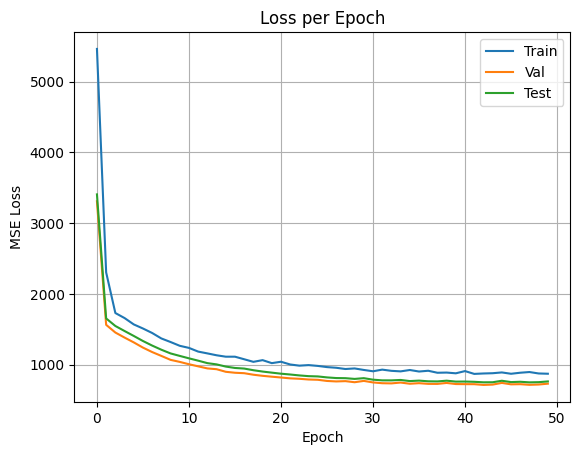

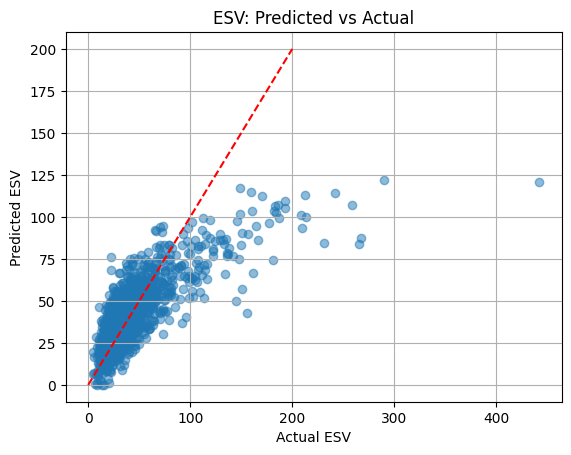

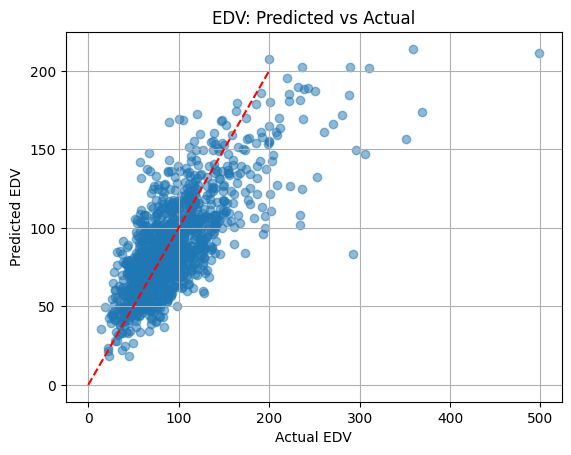

In [ ]:

# ─── PLOT LOSSES ───────────────────────────────────────────────────────────────
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ─── FINAL PRED VS ACTUAL ──────────────────────────────────────────────────────
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in test_loader:
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# ─── Plot ESV ──────────────────────────────────────────────────────────────────
plt.figure()
plt.scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5)
plt.xlabel("Actual ESV")
plt.ylabel("Predicted ESV")
plt.title("ESV: Predicted vs Actual")
plt.grid(True)
plt.plot([0, 200], [0, 200], 'r--')
plt.show()

# ─── Plot EDV ──────────────────────────────────────────────────────────────────
plt.figure()
plt.scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5)
plt.xlabel("Actual EDV")
plt.ylabel("Predicted EDV")
plt.title("EDV: Predicted vs Actual")
plt.grid(True)
plt.plot([0, 200], [0, 200], 'r--')
plt.show()

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from tqdm import tqdm

# ─── Load best model ───────────────────────────────────────────────────────────
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)
model.eval()

# ─── Containers for ground truth and predictions ──────────────────────────────
all_preds = []
all_targets = []

with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Evaluating on Test Set")
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in test_loader_tqdm:
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# ─── Convert predictions and targets to numpy ──────────────────────────────────
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

esv_pred = all_preds[:, 0]
edv_pred = all_preds[:, 1]
esv_true = all_targets[:, 0]
edv_true = all_targets[:, 1]

# ─── Compute EF ────────────────────────────────────────────────────────────────
ef_pred = (edv_pred - esv_pred) / (edv_pred + 1e-6)
ef_true = (edv_true - esv_true) / (edv_true + 1e-6)

# ─── Define metrics ────────────────────────────────────────────────────────────
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")

# ─── Print all metrics ─────────────────────────────────────────────────────────
print("\n📊 Test Set Evaluation Metrics")
print_metrics("ESV", esv_true, esv_pred)
print_metrics("EDV", edv_true, edv_pred)
print_metrics("EF", ef_true, ef_pred)

# ─── Overall RMSE ──────────────────────────────────────────────────────────────
total_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
print(f"\nTotal Volume RMSE (Joint): {total_rmse:.2f}")


Evaluating on Test Set: 100%|██████████| 40/40 [00:08<00:00,  4.63it/s]


📊 Test Set Evaluation Metrics
ESV - RMSE: 23.97 | MAE: 14.17 | R²: 0.550
EDV - RMSE: 30.44 | MAE: 21.32 | R²: 0.556
EF - RMSE: 0.11 | MAE: 0.09 | R²: 0.206

Total Volume RMSE (Joint): 27.40


In [10]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
import yaml

# ------------------------------
# Load model and stats
# ------------------------------
model = DualVolumeRegressor()
model.load_state_dict(torch.load('/content/best_model (4).pth'))
model.eval().cuda()

# Load normalization stats used during training
with open('/content/input_stats.yaml', 'r') as f:
    stats = yaml.safe_load(f)

# ------------------------------
# Load test dataset
# ------------------------------
test_dataset = DualEFVolumeDataset(
    metadata_path='/content/joint_esv_edv_dataset/joint_esv_edv_dataset/test/metadata.json',
    image_dir=Path('/content/joint_esv_edv_dataset/joint_esv_edv_dataset/test/images'),
    stats_path='/content/input_stats.yaml'
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------
# Prediction loop
# ------------------------------
y_pred_esv, y_pred_edv = [], []
y_true_esv, y_true_edv = [], []

with torch.no_grad():
    for batch in test_loader:
        (img_esv, area_esv, kp_esv,
         img_edv, area_edv, kp_edv), volumes = batch

        img_esv = img_esv.cuda()
        img_edv = img_edv.cuda()
        area_esv = area_esv.cuda()
        area_edv = area_edv.cuda()
        kp_esv = kp_esv.cuda()
        kp_edv = kp_edv.cuda()

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
        pred_esv, pred_edv = preds[:, 0], preds[:, 1]

        y_pred_esv.extend(pred_esv.cpu().numpy())
        y_pred_edv.extend(pred_edv.cpu().numpy())

        y_true_esv.extend(volumes[:, 0].cpu().numpy())
        y_true_edv.extend(volumes[:, 1].cpu().numpy())

# ------------------------------
# Convert to numpy + Compute EF
# ------------------------------
y_pred_esv = np.array(y_pred_esv)
y_pred_edv = np.array(y_pred_edv)
y_true_esv = np.array(y_true_esv)
y_true_edv = np.array(y_true_edv)

ef_pred = 1 - (y_pred_esv / y_pred_edv)
ef_true = 1 - (y_true_esv / y_true_edv)
ef_error = np.abs(ef_pred - ef_true)

# ------------------------------
# Print sample outputs
# ------------------------------
print(f"{'Idx':<5} {'Pred_ESV':>10} {'True_ESV':>10} {'Pred_EDV':>10} {'True_EDV':>10} {'Pred_EF':>10} {'True_EF':>10} {'EF_Error':>10}")
print('-' * 85)
for i in range(min(10, len(y_pred_esv))):
    print(f"{i:<5} {y_pred_esv[i]:10.2f} {y_true_esv[i]:10.2f} {y_pred_edv[i]:10.2f} {y_true_edv[i]:10.2f} {ef_pred[i]:10.2f} {ef_true[i]:10.2f} {ef_error[i]:10.2f}")


Idx     Pred_ESV   True_ESV   Pred_EDV   True_EDV    Pred_EF    True_EF   EF_Error
-------------------------------------------------------------------------------------
0          35.16      47.45      77.46     107.73       0.55       0.56       0.01
1          79.63      71.38     142.33     121.01       0.44       0.41       0.03
2          48.48      33.95      97.31      68.99       0.50       0.51       0.01
3          44.08      33.68      88.68      68.23       0.50       0.51       0.00
4          39.36      47.38      85.42     128.39       0.54       0.63       0.09
5          29.65      31.00      66.42      74.68       0.55       0.58       0.03
6          49.54      17.52     107.39      53.70       0.54       0.67       0.14
7          39.95      20.01      82.23      46.84       0.51       0.57       0.06
8          58.81      62.58     112.26     156.14       0.48       0.60       0.12
9          32.47      32.49      73.77      83.36       0.56       0.61       0.05


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

def print_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"{'R²':<6}: {r2:.4f}")
    print(f"{'MAE':<6}: {mae:.4f}")
    print(f"{'RMSE':<6}: {rmse:.4f}")

# ESV metrics
print_metrics("ESV", y_true_esv, y_pred_esv)

# EDV metrics
print_metrics("EDV", y_true_edv, y_pred_edv)

# EF metrics
print_metrics("EF", ef_true, ef_pred)



ESV Metrics:
R²    : 0.5499
MAE   : 14.1658
RMSE  : 23.9663

EDV Metrics:
R²    : 0.5564
MAE   : 21.3232
RMSE  : 30.4449

EF Metrics:
R²    : 0.2064
MAE   : 0.0884
RMSE  : 0.1089


# Model is not performing very good, Removing outliers and physically impossible values might decrease the error

In [14]:
import json
import numpy as np
from pathlib import Path
from collections import defaultdict
from scipy.stats import zscore

# Define paths to metadata.json files
base_dir = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset")
splits = ["train", "val", "test"]

# Load all metadata
all_data = []
split_data = {}

for split in splits:
    path = base_dir / split / "metadata.json"
    with open(path, 'r') as f:
        entries = json.load(f)
    split_data[split] = entries
    all_data.extend(entries)

print(f"\n✅ Loaded {sum(len(v) for v in split_data.values())} total entries.")

# Convert to arrays
def extract_volumes(data):
    esv, edv, ef = [], [], []
    for entry in data:
        vol = entry["volume"]
        label = entry["label"]
        if label == "esv":
            esv.append(vol)
        elif label == "edv":
            edv.append(vol)
    min_len = min(len(esv), len(edv))
    esv = np.array(esv[:min_len])
    edv = np.array(edv[:min_len])
    ef = 1 - (esv / edv)
    return esv, edv, ef

# Find outliers by z-score
def get_outliers(values):
    z = zscore(values)
    outlier_mask = np.abs(z) > 3
    return values[outlier_mask]

# Analyze all data
def analyze(name, esv, edv, ef):
    print(f"\n🔎 Split: {name}")
    for label, values in zip(["ESV", "EDV", "EF"], [esv, edv, ef]):
        outliers = get_outliers(values)
        if len(outliers) == 0:
            print(f"  {label}: No outliers")
        else:
            print(f"  {label}: {len(outliers)} outliers | Range: {outliers.min():.2f} – {outliers.max():.2f}")

# Analyze each split and overall
print("\n📊 Outlier Summary:")
for split in splits:
    esv, edv, ef = extract_volumes(split_data[split])
    analyze(split, esv, edv, ef)

# Combined analysis
all_esv, all_edv, all_ef = extract_volumes(all_data)
analyze("ALL", all_esv, all_edv, all_ef)



✅ Loaded 20048 total entries.

📊 Outlier Summary:

🔎 Split: train
  ESV: 172 outliers | Range: 151.85 – 612.49
  EDV: 139 outliers | Range: 228.98 – 695.04
  EF: 86 outliers | Range: 0.07 – 0.97

🔎 Split: val
  ESV: 28 outliers | Range: 149.14 – 319.47
  EDV: 24 outliers | Range: 224.57 – 400.20
  EF: 16 outliers | Range: 0.09 – 0.18

🔎 Split: test
  ESV: 29 outliers | Range: 151.07 – 441.91
  EDV: 24 outliers | Range: 231.76 – 498.47
  EF: 14 outliers | Range: 0.10 – 0.19

🔎 Split: ALL
  ESV: 231 outliers | Range: 151.07 – 612.49
  EDV: 183 outliers | Range: 228.98 – 695.04
  EF: 121 outliers | Range: 0.07 – 0.97


In [17]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import os

ROOT = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset/")
SPLITS = ["train", "val", "test"]

# Physically plausible ranges
EDV_MIN, EDV_MAX = 50, 300
ESV_MIN, ESV_MAX = 15, 100
EF_MIN, EF_MAX = 0.25, 0.80  # EF as fraction, i.e. 25%-80%

def load_metadata(split):
    with open(ROOT/split/"metadata.json", "r") as f:
        return json.load(f)

def save_metadata(split, entries):
    with open(ROOT/split/"metadata_clean.json", "w") as f:
        json.dump(entries, f, indent=2)

def compute_ef(esv, edv):
    return 1 - (esv / edv)

def delete_images(video_id, split):
    # Delete both esv and edv frames images
    for label in ['esv', 'edv']:
        # Find all matching files for this video and label
        folder = ROOT/split/"images"
        # We'll delete files matching {video_id}_{label}_f*.jpg
        for img_file in folder.glob(f"{video_id}_{label}_f*.jpg"):
            try:
                img_file.unlink()
            except Exception as e:
                print(f"Failed to delete {img_file}: {e}")

# Step 1: Load all splits metadata into DataFrames
dfs = []
for split in SPLITS:
    entries = load_metadata(split)
    df = pd.DataFrame(entries)
    df["split"] = split
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

print(f"✅ Loaded {len(all_df)} total frames across {len(SPLITS)} splits.")

# Step 2: Group by video_id and ensure pairs (esv+edv)
grouped = all_df.groupby("video_id")

# We'll build a mask of valid videos after physical plausibility filtering
valid_videos_physical = []

removed_videos_physical = 0

print("\nRemoving videos violating physical plausibility constraints...")

for vid, group in grouped:
    if set(group['label']) != {'esv', 'edv'}:
        # Missing one frame, remove video
        removed_videos_physical += 1
        continue

    # Extract esv and edv rows
    esv_row = group[group['label'] == 'esv'].iloc[0]
    edv_row = group[group['label'] == 'edv'].iloc[0]

    esv_vol = esv_row['volume']
    edv_vol = edv_row['volume']

    # Calculate EF
    ef = compute_ef(esv_vol, edv_vol)

    # Check physical plausibility
    if not (EDV_MIN <= edv_vol <= EDV_MAX):
        removed_videos_physical += 1
        continue
    if not (ESV_MIN <= esv_vol <= ESV_MAX):
        removed_videos_physical += 1
        continue
    if not (EF_MIN <= ef <= EF_MAX):
        removed_videos_physical += 1
        continue
    if esv_vol > edv_vol:
        removed_videos_physical += 1
        continue

    # Passed all checks
    valid_videos_physical.append(vid)

print(f"Removed {removed_videos_physical} videos due to physical implausibility.")

# Filter all_df to keep only valid videos
all_df = all_df[all_df['video_id'].isin(valid_videos_physical)].reset_index(drop=True)

# Step 3: Calculate EF column for each frame (duplicate for each row)
ef_vals = []
for idx, row in all_df.iterrows():
    vid = row['video_id']
    group = all_df[all_df['video_id'] == vid]
    esv_vol = group[group['label']=='esv']['volume'].values[0]
    edv_vol = group[group['label']=='edv']['volume'].values[0]
    ef_vals.append(compute_ef(esv_vol, edv_vol))
all_df['ef'] = ef_vals

print(f"\nRemaining frames after physical filtering: {len(all_df)} (videos: {len(valid_videos_physical)})")

# Step 4: Detect statistical outliers using IQR method per split for esv, edv, ef

def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return (df[col] < lower_bound) | (df[col] > upper_bound), (lower_bound, upper_bound)

print("\nDetecting outliers using IQR per split:")

outliers_info = {}

for split in SPLITS:
    split_df = all_df[all_df['split']==split]
    outliers_info[split] = {}
    for metric in ['volume', 'ef']:
        if metric == 'volume':
            # separate ESV and EDV outliers for volumes
            esv_df = split_df[split_df['label']=='esv']
            edv_df = split_df[split_df['label']=='edv']
            esv_outliers, esv_bounds = detect_outliers_iqr(esv_df, 'volume')
            edv_outliers, edv_bounds = detect_outliers_iqr(edv_df, 'volume')
            outliers_info[split]['esv'] = {'mask': esv_outliers, 'bounds': esv_bounds}
            outliers_info[split]['edv'] = {'mask': edv_outliers, 'bounds': edv_bounds}
        else:
            ef_outliers, ef_bounds = detect_outliers_iqr(split_df, 'ef')
            outliers_info[split]['ef'] = {'mask': ef_outliers, 'bounds': ef_bounds}

    print(f"\nSplit: {split}")
    print(f" ESV bounds: {outliers_info[split]['esv']['bounds']}")
    print(f" EDV bounds: {outliers_info[split]['edv']['bounds']}")
    print(f" EF bounds : {outliers_info[split]['ef']['bounds']}")

# Step 5: Remove videos with any outlier frames (ESV, EDV, or EF) in any split

valid_videos_outliers = []
removed_videos_outliers = 0

print("\nRemoving videos with statistical outliers in ESV, EDV, or EF...")

grouped = all_df.groupby("video_id")
for vid, group in grouped:
    split = group['split'].values[0]
    # Check esv outlier
    esv_row = group[group['label']=='esv'].iloc[0]
    edv_row = group[group['label']=='edv'].iloc[0]

    esv_outlier_mask = outliers_info[split]['esv']['mask']
    edv_outlier_mask = outliers_info[split]['edv']['mask']
    ef_outlier_mask = outliers_info[split]['ef']['mask']

    esv_is_outlier = esv_outlier_mask[esv_row.name]
    edv_is_outlier = edv_outlier_mask[edv_row.name]
    ef_is_outlier = outliers_info[split]['ef']['mask'][esv_row.name] or outliers_info[split]['ef']['mask'][edv_row.name]

    if esv_is_outlier or edv_is_outlier or ef_is_outlier:
        removed_videos_outliers += 1
    else:
        valid_videos_outliers.append(vid)

print(f"Removed {removed_videos_outliers} videos due to statistical outliers.")

# Filter again after outlier removal
all_df = all_df[all_df['video_id'].isin(valid_videos_outliers)].reset_index(drop=True)

# Step 6: Save cleaned metadata.json per split and delete removed images

for split in SPLITS:
    split_df = all_df[all_df['split'] == split]
    # Save metadata
    save_metadata(split, split_df.drop(columns=['split', 'ef']).to_dict(orient='records'))

    # Get all removed videos in this split
    orig_df = pd.DataFrame(load_metadata(split))
    orig_vids = set(orig_df['video_id'])
    cleaned_vids = set(split_df['video_id'])
    removed_vids = orig_vids - cleaned_vids

    print(f"\nSplit '{split}' removed {len(removed_vids)} videos. Deleting their images...")

    for vid in removed_vids:
        delete_images(vid, split)

print("\nCleanup complete.")


✅ Loaded 20048 total frames across 3 splits.

Removing videos violating physical plausibility constraints...
Removed 1915 videos due to physical implausibility.

Remaining frames after physical filtering: 16218 (videos: 8109)

Detecting outliers using IQR per split:

Split: train
 ESV bounds: (np.float64(-5.049665999999998), np.float64(78.96930006))
 EDV bounds: (np.float64(11.738701206250006), np.float64(162.40943363625))
 EF bounds : (np.float64(0.3970352554210003), np.float64(0.7817043995564632))

Split: val
 ESV bounds: (np.float64(-4.205916573749999), np.float64(79.32654545625))
 EDV bounds: (np.float64(14.22600070625002), np.float64(161.15192793625))
 EF bounds : (np.float64(0.4095043445313943), np.float64(0.7710569576802847))

Split: test
 ESV bounds: (np.float64(-3.654152742500006), np.float64(76.67472247750001))
 EDV bounds: (np.float64(8.680930825000004), np.float64(166.763152385))
 EF bounds : (np.float64(0.3882237106680143), np.float64(0.7814586154062192))

Removing videos 

In [18]:
import json
from pathlib import Path

ROOT = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset/")
SPLITS = ["train", "val", "test"]

for split in SPLITS:
    with open(ROOT/split/"metadata_clean.json", "r") as f:
        entries = json.load(f)
    vids = set(e['video_id'] for e in entries)
    print(f"{split}: {len(vids)} videos, {len(entries)} frames")


train: 5398 videos, 10796 frames
val: 922 videos, 1844 frames
test: 948 videos, 1896 frames


In [19]:
from google.colab import files
import shutil

# Create zip
shutil.make_archive('/content/joint_esv_edv_dataset/joint_esv_edv_dataset', 'zip', '/content/joint_esv_edv_dataset/joint_esv_edv_dataset')

# Download
files.download('/content/joint_esv_edv_dataset/joint_esv_edv_dataset.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Retrain

In [ ]:
import json
import numpy as np
from pathlib import Path

# Path to your train metadata
meta_path = Path("/content/joint_esv_edv_dataset/joint_esv_edv_dataset/train/metadata.json")

# Load all entries
with open(meta_path, 'r') as f:
    entries = json.load(f)

all_kps = []    # will be list of shape-(80,) arrays
all_areas = []  # list of scalars

for e in entries:
    all_kps.append(np.array(e["keypoints"], dtype=np.float32))
    all_areas.append(float(e["area"]))

all_kps = np.stack(all_kps, axis=0)       # shape (N, 80)
all_areas = np.array(all_areas)           # shape (N,)

# Compute mean & std
kp_mean = all_kps.mean(axis=0)            # (80,)
kp_std  = all_kps.std(axis=0)             # (80,)
area_mean = all_areas.mean()              # scalar
area_std  = all_areas.std()               # scalar

print("Keypoint mean shape:", kp_mean.shape)
print("Keypoint std  shape:", kp_std.shape)
print("Area mean:", area_mean)
print("Area std :", area_std)

# If you prefer a single scalar for keypoints (shared across dims):
print("Overall KP mean:", kp_mean.mean())
print("Overall KP std :", kp_std.mean())


In [ ]:
import yaml
import numpy as np
from pathlib import Path


# Create a dict that’s YAML-serializable
stats = {
    'kp_mean': kp_mean.tolist(),
    'kp_std':  kp_std.tolist(),
    'area_mean': float(area_mean),
    'area_std':  float(area_std),
}

# Write to stats.yaml
out_path = Path("input_stats.yaml")
with out_path.open('w') as f:
    yaml.safe_dump(stats, f, default_flow_style=False)

print(f"Saved normalization stats to {out_path.resolve()}")


In [ ]:

# ─── DATA LOADERS ─────────────────────────────────────────────────────────────
train_ds = DualEFVolumeDataset(ROOT/"train"/"metadata.json", ROOT/"train"/"images/")
val_ds   = DualEFVolumeDataset(ROOT/"val"/"metadata.json",   ROOT/"val"/"images/")
test_ds  = DualEFVolumeDataset(ROOT/"test"/"metadata.json",  ROOT/"test"/"images/")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ─── MODEL, LOSS, OPTIMIZER & SCHEDULER ────────────────────────────────────────
model = DualVolumeRegressor().to(DEVICE)
# Combined MSE + EF loss
def ef_loss(esv_pred, edv_pred, esv_gt, edv_gt):
    ef_pred = (edv_pred - esv_pred) / (edv_pred + 1e-6)
    ef_gt   = (edv_gt   - esv_gt)   / (edv_gt   + 1e-6)
    return nn.MSELoss()(ef_pred, ef_gt)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:

from tqdm import tqdm
import time

train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch # {epoch}')
    start_time = time.time()

    # ─ Train ─
    model.train()
    running_train = 0.0
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False):
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        esv_pred, edv_pred = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv).unbind(1)
        loss_main = criterion(torch.stack([esv_pred, edv_pred], dim=1), targets)
        loss_ef   = ef_loss(esv_pred, edv_pred, targets[:,0], targets[:,1])
        loss = loss_main + 0.3 * loss_ef
        loss.backward()
        optimizer.step()

        running_train += loss_main.item() * img_esv.size(0)

    train_loss = running_train / len(train_ds)
    train_losses.append(train_loss)

    # ─ Validation ─
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False):
            img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
            img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
            targets = targets.to(DEVICE)

            esv_pred, edv_pred = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv).unbind(1)
            loss_main = criterion(torch.stack([esv_pred, edv_pred], dim=1), targets)
            running_val += loss_main.item() * img_esv.size(0)

    val_loss = running_val / len(val_ds)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

    # ─ Test ─
    running_test = 0.0
    with torch.no_grad():
        for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in tqdm(test_loader, desc=f"Epoch {epoch}/{EPOCHS} [Test]", leave=False):
            img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
            img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
            targets = targets.to(DEVICE)

            preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
            loss_main = criterion(preds, targets)
            running_test += loss_main.item() * img_esv.size(0)

    test_loss = running_test / len(test_ds)
    test_losses.append(test_loss)

    scheduler.step()

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} | Train: {train_loss:.3f} | Val: {val_loss:.3f} | Test: {test_loss:.3f} | Time: {elapsed:.1f}s")

print(f"Training complete. Best model saved to '{best_model_path}' with val loss {best_val_loss:.4f}")


## Evaluate Again

In [ ]:

# ─── PLOT LOSSES ───────────────────────────────────────────────────────────────
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ─── FINAL PRED VS ACTUAL ──────────────────────────────────────────────────────
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in test_loader:
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# ─── Plot ESV ──────────────────────────────────────────────────────────────────
plt.figure()
plt.scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5)
plt.xlabel("Actual ESV")
plt.ylabel("Predicted ESV")
plt.title("ESV: Predicted vs Actual")
plt.grid(True)
plt.plot([0, 200], [0, 200], 'r--')
plt.show()

# ─── Plot EDV ──────────────────────────────────────────────────────────────────
plt.figure()
plt.scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5)
plt.xlabel("Actual EDV")
plt.ylabel("Predicted EDV")
plt.title("EDV: Predicted vs Actual")
plt.grid(True)
plt.plot([0, 200], [0, 200], 'r--')
plt.show()

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from tqdm import tqdm

# ─── Load best model ───────────────────────────────────────────────────────────
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)
model.eval()

# ─── Containers for ground truth and predictions ──────────────────────────────
all_preds = []
all_targets = []

with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Evaluating on Test Set")
    for (img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv), targets in test_loader_tqdm:
        img_esv, area_esv, kp_esv = img_esv.to(DEVICE), area_esv.to(DEVICE), kp_esv.to(DEVICE)
        img_edv, area_edv, kp_edv = img_edv.to(DEVICE), area_edv.to(DEVICE), kp_edv.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# ─── Convert predictions and targets to numpy ──────────────────────────────────
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

esv_pred = all_preds[:, 0]
edv_pred = all_preds[:, 1]
esv_true = all_targets[:, 0]
edv_true = all_targets[:, 1]

# ─── Compute EF ────────────────────────────────────────────────────────────────
ef_pred = (edv_pred - esv_pred) / (edv_pred + 1e-6)
ef_true = (edv_true - esv_true) / (edv_true + 1e-6)

# ─── Define metrics ────────────────────────────────────────────────────────────
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")

# ─── Print all metrics ─────────────────────────────────────────────────────────
print("\n📊 Test Set Evaluation Metrics")
print_metrics("ESV", esv_true, esv_pred)
print_metrics("EDV", edv_true, edv_pred)
print_metrics("EF", ef_true, ef_pred)

# ─── Overall RMSE ──────────────────────────────────────────────────────────────
total_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
print(f"\nTotal Volume RMSE (Joint): {total_rmse:.2f}")


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
import yaml

# ------------------------------
# Load model and stats
# ------------------------------
model = DualVolumeRegressor()
model.load_state_dict(torch.load('/content/best_model (4).pth'))
model.eval().cuda()

# Load normalization stats used during training
with open('/content/input_stats.yaml', 'r') as f:
    stats = yaml.safe_load(f)

# ------------------------------
# Load test dataset
# ------------------------------
test_dataset = DualEFVolumeDataset(
    metadata_path='/content/joint_esv_edv_dataset/joint_esv_edv_dataset/test/metadata.json',
    image_dir=Path('/content/joint_esv_edv_dataset/joint_esv_edv_dataset/test/images'),
    stats_path='/content/input_stats.yaml'
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------
# Prediction loop
# ------------------------------
y_pred_esv, y_pred_edv = [], []
y_true_esv, y_true_edv = [], []

with torch.no_grad():
    for batch in test_loader:
        (img_esv, area_esv, kp_esv,
         img_edv, area_edv, kp_edv), volumes = batch

        img_esv = img_esv.cuda()
        img_edv = img_edv.cuda()
        area_esv = area_esv.cuda()
        area_edv = area_edv.cuda()
        kp_esv = kp_esv.cuda()
        kp_edv = kp_edv.cuda()

        preds = model(img_esv, area_esv, kp_esv, img_edv, area_edv, kp_edv)
        pred_esv, pred_edv = preds[:, 0], preds[:, 1]

        y_pred_esv.extend(pred_esv.cpu().numpy())
        y_pred_edv.extend(pred_edv.cpu().numpy())

        y_true_esv.extend(volumes[:, 0].cpu().numpy())
        y_true_edv.extend(volumes[:, 1].cpu().numpy())

# ------------------------------
# Convert to numpy + Compute EF
# ------------------------------
y_pred_esv = np.array(y_pred_esv)
y_pred_edv = np.array(y_pred_edv)
y_true_esv = np.array(y_true_esv)
y_true_edv = np.array(y_true_edv)

ef_pred = 1 - (y_pred_esv / y_pred_edv)
ef_true = 1 - (y_true_esv / y_true_edv)
ef_error = np.abs(ef_pred - ef_true)

# ------------------------------
# Print sample outputs
# ------------------------------
print(f"{'Idx':<5} {'Pred_ESV':>10} {'True_ESV':>10} {'Pred_EDV':>10} {'True_EDV':>10} {'Pred_EF':>10} {'True_EF':>10} {'EF_Error':>10}")
print('-' * 85)
for i in range(min(10, len(y_pred_esv))):
    print(f"{i:<5} {y_pred_esv[i]:10.2f} {y_true_esv[i]:10.2f} {y_pred_edv[i]:10.2f} {y_true_edv[i]:10.2f} {ef_pred[i]:10.2f} {ef_true[i]:10.2f} {ef_error[i]:10.2f}")


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

def print_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"{'R²':<6}: {r2:.4f}")
    print(f"{'MAE':<6}: {mae:.4f}")
    print(f"{'RMSE':<6}: {rmse:.4f}")

# ESV metrics
print_metrics("ESV", y_true_esv, y_pred_esv)

# EDV metrics
print_metrics("EDV", y_true_edv, y_pred_edv)

# EF metrics
print_metrics("EF", ef_true, ef_pred)
